## Machine Learning models 

This script contains the code for performing the training of the models. The ones used where where the SVM, Neural networks and XGBoost

In [11]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn 
import os
import xgboost as xgb
import winsound
import pickle
import time

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC##
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score, f1_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Import data and Feature selection 


Number of Total variable variables:  26 =  ['meanF0Hz', 'stdevF0Hz', 'HNR', 'CPPs', 'Jitter', 'Shimmer', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'Age', 'Gender_f', 'Gender_m', 'VHI', 'RSI', 'r'] 

Number of acustic variables:  6
Number of cepstral variables:  15
Feature selection:  ['meanF0Hz', 'HNR', 'CPPs', 'Shimmer', 'M7', 'M8', 'Age', 'VHI', 'RSI', 'r']


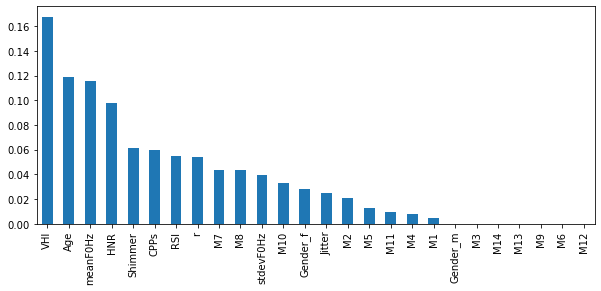

In [12]:
dts =  '2s' # ;'1s' ;'svd'
dataset = 'dados_' + dts + '_modelos.csv'

#import the data with all the features
x = pd.read_csv(os.path.join('Dados',dataset)) 

y = x[['Diagnostics']] # define the output
y = y.values
y = y.ravel()

X1 = x.drop(columns=['voiceID', 'Diagnostics','DiagnosticsSVM', 'ID']) # remove unecessary columns
print('Number of Total variable variables: ', len(X1.columns), '= ', list(X1.columns), '\n')

#Scale the input
X_transform = StandardScaler().fit(X1) 
X_scaled = pd.DataFrame(X_transform.transform(X1), columns = X1.columns)

# Divide the input into different datasets, depending on the type of features: Acustic, Cepstral 
X_acust = X_scaled[['meanF0Hz', 'stdevF0Hz', 'HNR', 'Jitter', 'Shimmer','r']]
X_spect = X_scaled[[ 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13',
                    'M14', 'CPPs']]
print('Number of acustic variables: ', len(X_acust.columns))
print('Number of cepstral variables: ', len(X_spect.columns))

#Feature selection based on Mutual inforamtion classification
mutual_info = mutual_info_classif(X_scaled, y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_scaled.columns
mutual_info.sort_values(ascending=False)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10,4))


sel_cols = SelectKBest(mutual_info_classif, k=10)
sel_cols.fit(X_scaled, y)
X_ff = X_scaled[X_scaled.columns[sel_cols.get_support()]]

print('Feature selection: ', list(X_ff.columns))

#Feature selection without CHI and RSI
X_all_val = X_scaled.drop(columns = ['VHI', 'RSI']) # This one is for testing if the indexes are iimportant and to match it with SVD that doesnt haver neither RSI or VHI

mutual_info_val = mutual_info_classif(X_all_val, y)
mutual_info_val = pd.Series(mutual_info_val)
mutual_info_val.index = X_all_val.columns
mutual_info_val.sort_values(ascending=False)
#mutual_info_val.sort_values(ascending=False).plot.bar(figsize=(10,4))

#sel_cols = SelectKBest(mutual_info_classif, k=10)
sel_cols.fit(X_all_val, y)
X_ff_val = X_scaled[X_all_val.columns[sel_cols.get_support()]]

#X_ff_val.columns

In [13]:
# For validation porpuses 

x_svd= pd.read_csv(os.path.join('Dados','dados_svd_modelos.csv')) 

#x_svd = x_svd[(x_svd['duration_s_'] >= 0.8) & (x_svd['duration_s_'] <= 1.2)]

y_svd = x_svd[['Diagnostics']] # define the output
y_svd = y_svd.values
y_svd = y_svd.ravel()

X_svd = x_svd.drop(columns = ['voiceID', 'Diagnostics', 'duration_s_'])
cols = X_all_val.columns.to_list()
X_svd = X_svd[cols]

print('Number of Total variable variables: ', len(X_svd.columns), '= ', list(X_svd.columns), '\n')
X_transform = MinMaxScaler().fit(X_svd) 
X_scaled_svd = pd.DataFrame(X_transform.transform(X_svd), columns = X_svd.columns)

# Divide the input into different datasets, depending on the type of features: Acustic, Cepstral 
X_acust_svd = X_scaled_svd[['meanF0Hz', 'stdevF0Hz', 'HNR', 'Jitter', 'Shimmer','r']]
X_spect_svd = X_scaled_svd[[ 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13',
                    'M14', 'CPPs']]

X_ff_svd = X_scaled_svd[X_all_val.columns[sel_cols.get_support()]]
print('Feature selection: ', list(X_ff_svd.columns))

Number of Total variable variables:  24 =  ['meanF0Hz', 'stdevF0Hz', 'HNR', 'CPPs', 'Jitter', 'Shimmer', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'Age', 'Gender_f', 'Gender_m', 'r'] 

Feature selection:  ['meanF0Hz', 'stdevF0Hz', 'HNR', 'CPPs', 'Shimmer', 'M7', 'M8', 'M10', 'Age', 'r']


In [14]:
import seaborn as sn
import matplotlib.pyplot as plt

X = x.drop(columns=['voiceID', 'Gender_f','DiagnosticsSVM', 'ID'])
X = X[['meanF0Hz', 'stdevF0Hz', 'Jitter', 'Shimmer','HNR', 'CPPs', 'r', 
        'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 
        'Age', 'Gender_m', 'VHI', 'RSI', 'Diagnostics']]
      
#X['MFCC'] = X_scaled[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14']].values.tolist()
X = X.rename(columns={'Gender_m':'Gender'})
# Do the correlation matrix between the r and the output
r = X
corr_matrix = r.corr()
#plt.figure(figsize=(22, 18))
#sn.heatmap(corr_matrix,annot=True, cmap= 'RdBu', cbar_kws={ 'aspect': 40})
#plt.show()

## Support Vector Machine

Best parameters : {'C': 91, 'gamma': 0.01, 'kernel': 'sigmoid'}
Best score : 0.7080234159779615


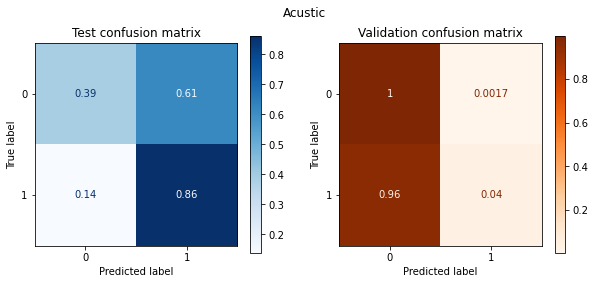

Best parameters : {'C': 6, 'gamma': 5, 'kernel': 'rbf'}
Best score : 0.9473966942148762


C:\Users\Marta Sousa\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


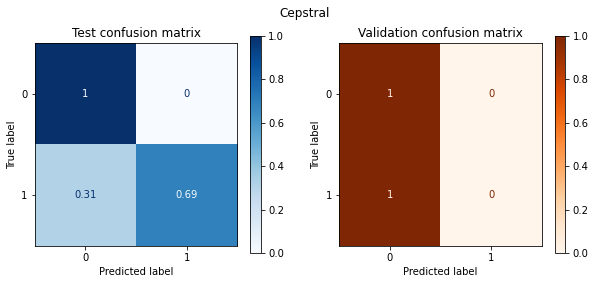

Best parameters : {'C': 6, 'gamma': 1, 'kernel': 'rbf'}
Best score : 0.910702479338843


C:\Users\Marta Sousa\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


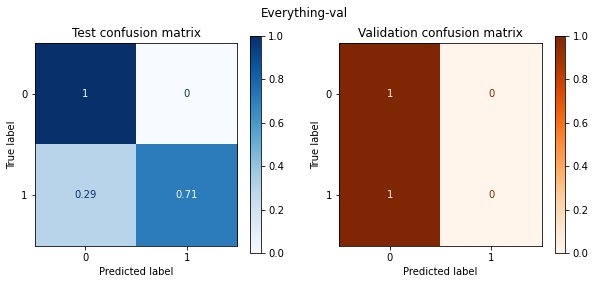

Best parameters : {'C': 6, 'gamma': 5, 'kernel': 'rbf'}
Best score : 0.9109504132231405


C:\Users\Marta Sousa\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


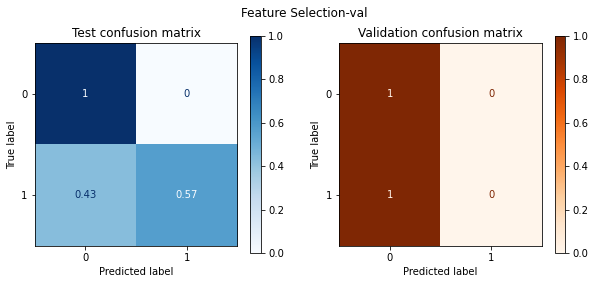

Best parameters : {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best score : 0.9221694214876035


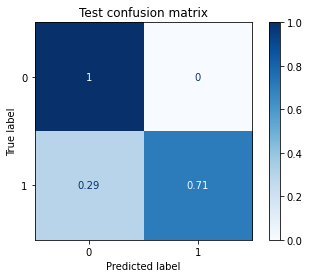

Best parameters : {'C': 6, 'gamma': 5, 'kernel': 'rbf'}
Best score : 0.9171763085399449


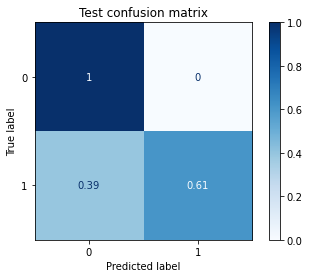

                 dataset  AUC-train  AUC-t-std  Accuracy-train  \
0                Acustic     0.6997     0.0154          0.6555   
1               Cepstral     1.0000     0.0000          1.0000   
2         Everything-val     1.0000     0.0000          1.0000   
3  Feature Selection-val     1.0000     0.0000          1.0000   
4             Everything     1.0000     0.0000          1.0000   
5      Feature Selection     1.0000     0.0000          1.0000   

   Accuracy-t-std  Precision-train  Precision-t-std  Recall-train  \
0          0.0171            0.631            0.018        0.8177   
1          0.0000            1.000            0.000        1.0000   
2          0.0000            1.000            0.000        1.0000   
3          0.0000            1.000            0.000        1.0000   
4          0.0000            1.000            0.000        1.0000   
5          0.0000            1.000            0.000        1.0000   

   Recall-t-std  F1 score-train  ...  AUC-test  Accur

In [25]:
svm_results = pd.DataFrame(columns = ['dataset','AUC-train', 'AUC-t-std','Accuracy-train','Accuracy-t-std',
                                      'Precision-train', 'Precision-t-std','Recall-train', 'Recall-t-std',
                                      'F1 score-train', 'F1 score-t-std','AUC-cv', 'AUC-std','Accuracy-cv','Accuracy-std',
                                      'Precision-cv', 'Precision-std','Recall-cv', 'Recall-std',
                                      'F1 score-cv', 'F1 score-std', 'AUC-test', 'Accuracy-test',
                                      'Precision-test', 'Recall-test', 'F1 score-test','params',
                                      'fit-time', 'fit-std', 'score-time', 'score-std'])
svm_val = pd.DataFrame(columns = ['dataset','AUC', 'Accuracy','Precision', 'Recall', 'F1 score'])

for n in range(1,7):
    if n == 1:
        X = X_acust
        dataset = 'Acustic'
        X_val = X_acust_svd
    elif n == 2:
        X = X_spect
        dataset = 'Cepstral'  
        X_val = X_spect_svd
    elif n == 3:
        X = X_all_val
        dataset = 'Everything-val'
        X_val = X_scaled_svd
    elif n == 4 : 
        X = X_ff_val  #From feature selction
        dataset = 'Feature Selection-val'
        X_val = X_ff_svd 
    elif n == 5:
        X = X_scaled
        dataset = 'Everything'
    elif n == 6: 
        X = X_ff  #From feature selction
        dataset = 'Feature Selection'

    #SVM
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
    #X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.5, random_state=1)  

    tuned_parameters = [{'C': range(1,102, 5) ,
                         'gamma': [ 0.01, 0.1, 0.5, 1, 5],
                         'kernel': ['rbf', 'linear', 'sigmoid']}]


    gdc = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'], 
                       refit='roc_auc', return_train_score=True)
    gdc.fit(X_train, y_train)
    print('Best parameters : ' + str(gdc.best_params_))
    print('Best score : ' + str(gdc.best_score_))
    
    #Save the trained model for validation after
    pkl_file ="Modelos/SVM_" + dataset + "_model.pkl"  
    with open(pkl_file, 'wb') as file:
        pickle.dump(gdc, file)
    
    y_pred = gdc.predict(X_test)
    auc_test = roc_auc_score(y_test, y_pred)
    acc_test = accuracy_score(y_test, y_pred)
    rec_test = recall_score(y_test, y_pred)
    pre_test = precision_score(y_test, y_pred)
    f1_test =f1_score(y_test, y_pred)
    
       

    if n in range(1, 5):
        #For validation porpuses, using SVD
        y_pred_svd = gdc.predict(X_val)
        auc_val = roc_auc_score(y_svd, y_pred_svd)
        acc_val = accuracy_score(y_svd, y_pred_svd)
        rec_val = recall_score(y_svd, y_pred_svd)
        pre_val = precision_score(y_svd, y_pred_svd)
        f1_val =f1_score(y_svd, y_pred_svd)

        #Get the confusion matrix for the test and validation data
        cm = confusion_matrix(y_test, y_pred, normalize = 'true')
        cm2 = confusion_matrix(y_svd, y_pred_svd, normalize = 'true')
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
        f.suptitle(dataset)

        #Confusion matrix for test
        ax1.set_title("Test confusion matrix")
        disp1= ConfusionMatrixDisplay(confusion_matrix=cm)
        disp1.plot(ax = ax1, cmap=plt.cm.Blues)
        
                
        #Confusioin matrix of validation
        ax2.set_title("Validation confusion matrix")
        disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
        disp2.plot(ax = ax2, cmap=plt.cm.Oranges)

        #disp.plot(cmap=plt.cm.Oranges)
        #plt.title('Validation confusion matrix')
        
        plt.show()
        
        svm_val = svm_val.append({'dataset': dataset,  
                                'AUC' : auc_val.round(4),  #area under the curve
                                'Accuracy': acc_val.round(4),   #
                                'Precision': pre_val.round(4),   #
                                'Recall' : rec_val.round(4), #how many observations out of all positive observations have we classified as positive
                                'F1 score' : f1_val.round(4)},
                                ignore_index = True)
    else:
        #Get the confusion matrix
        cm = confusion_matrix(y_test, y_pred, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Test confusion matrix')
        plt.show()     

    

    best_index = np.nonzero(gdc.cv_results_["mean_test_roc_auc"] == gdc.best_score_)[0][0]
    auc = gdc.cv_results_["mean_test_roc_auc"][best_index]
    auc_std = gdc.cv_results_["std_test_roc_auc"][best_index]
    acc = gdc.cv_results_["mean_test_accuracy"][best_index]
    acc_std = gdc.cv_results_["std_test_accuracy"][best_index]
    pre = gdc.cv_results_["mean_test_precision"][best_index]
    pre_std = gdc.cv_results_["std_test_precision"][best_index]
    recall = gdc.cv_results_["mean_test_recall"][best_index]
    recall_std = gdc.cv_results_["std_test_recall"][best_index]
    f1 =  gdc.cv_results_["mean_test_f1"][best_index]
    f1_std =  gdc.cv_results_["std_test_f1"][best_index]
    
    auc_train = gdc.cv_results_["mean_train_roc_auc"][best_index]
    auc_train_std = gdc.cv_results_["std_train_roc_auc"][best_index]
    acc_train = gdc.cv_results_["mean_train_accuracy"][best_index]
    acc_train_std = gdc.cv_results_["std_train_accuracy"][best_index]
    pre_train = gdc.cv_results_["mean_train_precision"][best_index]
    pre_train_std = gdc.cv_results_["std_train_precision"][best_index]
    recall_train = gdc.cv_results_["mean_train_recall"][best_index]
    recall_train_std = gdc.cv_results_["std_train_recall"][best_index]
    f1_train =  gdc.cv_results_["mean_train_f1"][best_index]
    f1_train_std =  gdc.cv_results_["std_train_f1"][best_index]
    
    fit_time = gdc.cv_results_["mean_fit_time"][best_index]
    fit_time_std = gdc.cv_results_["std_fit_time"][best_index]
    score_time = gdc.cv_results_["mean_score_time"][best_index]
    score_time_std = gdc.cv_results_["std_score_time"][best_index]
    
    svm_results = svm_results.append({'dataset': dataset, 
                                'AUC-train' : auc_train.round(4),  #area under the curve
                                'AUC-t-std' : auc_train_std.round(4),
                                'Accuracy-train': acc_train.round(4),   #
                                'Accuracy-t-std': acc_train_std.round(4),
                                'Precision-train': pre_train.round(4),   #
                                'Precision-t-std': pre_train_std.round(4),
                                'Recall-train' : recall_train.round(4), #how many observations out of all positive observations have we classified as positive
                                'Recall-t-std' : recall_train_std.round(4),
                                'F1 score-train' : f1_train.round(4),   #It’s the harmonic mean between precision and recall
                                'F1 score-t-std' : f1_train_std.round(4),
                                'AUC-cv' : auc.round(4),  #area under the curve
                                'AUC-std' : auc_std.round(4),
                                'Accuracy-cv': acc.round(4),   #
                                'Accuracy-std': acc_std.round(4),
                                'Precision-cv': pre.round(4),   #
                                'Precision-std': pre_std.round(4),
                                'Recall-cv' : recall.round(4), #how many observations out of all positive observations have we classified as positive
                                'Recall-std' : recall_std.round(4),
                                'F1 score-cv' : f1.round(4),   #It’s the harmonic mean between precision and recall
                                'F1 score-std' : f1_std.round(4),
                                'AUC-test': auc_test.round(4),
                                'Accuracy-test': acc_test.round(4),
                                'Precision-test': pre_test.round(4), 
                                'Recall-test': rec_test.round(4),
                                'F1 score-test': f1_test.round(4),
                                'params' : gdc.best_params_,
                                'fit-time' : fit_time.round(4),
                                'fit-std' : fit_time_std,
                                'score-time' : score_time.round(4),
                                'score-std': score_time_std}, ignore_index = True)


#winsound.Beep(500, 1000)
print(svm_results)
print(svm_val)

In [26]:
svm_results= svm_results.round(4)
svmm = pd.concat([svm_results, svm_val])
save = 'svm_' + dts + '.xlsx'
svmm.to_csv(os.path.join('Modelos', save), index=False)

## XGBoost

Best Parameters Acustic: max depth: 9 | eta : 0.25 | gamma : 0 with AUC: 0.928


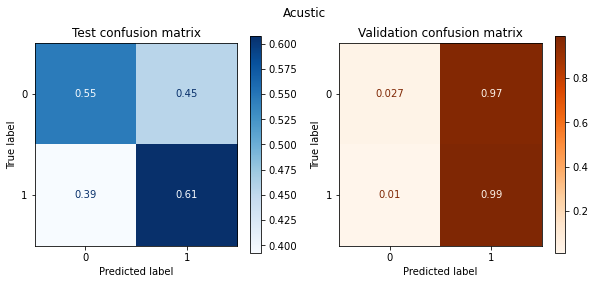

Best Parameters Cepstral: max depth: 9 | eta : 0.25 | gamma : 0 with AUC: 0.942


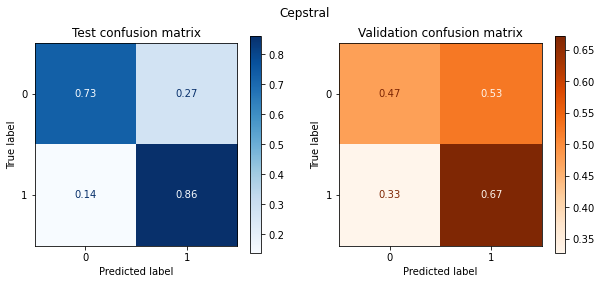

Best Parameters Everything-val: max depth: 9 | eta : 0.25 | gamma : 0 with AUC: 0.969


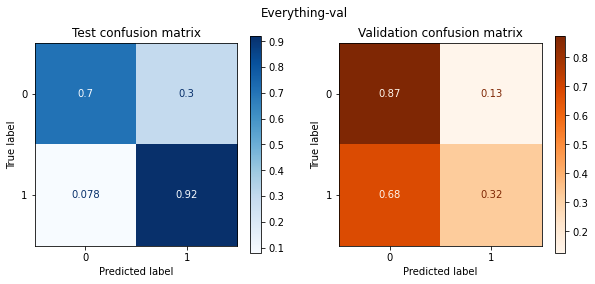

Best Parameters Feature Selection-val: max depth: 9 | eta : 0.25 | gamma : 0 with AUC: 0.953


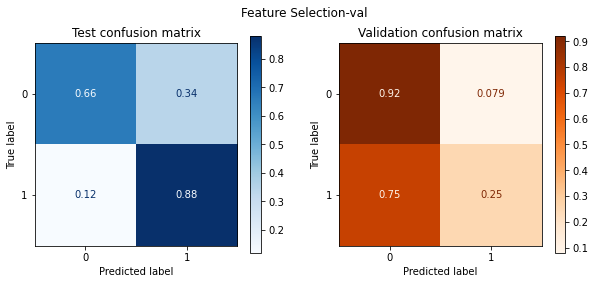

Best Parameters Everything: max depth: 9 | eta : 0.25 | gamma : 0 with AUC: 0.976


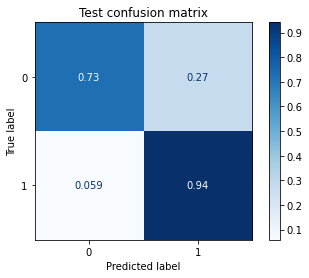

Best Parameters Feature Selection: max depth: 9 | eta : 0.25 | gamma : 0 with AUC: 0.964


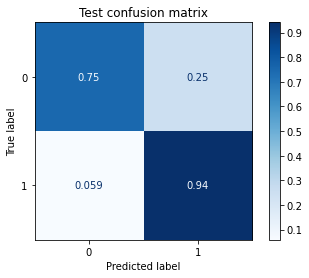

                  Modelo  AUC-train  AUC-train-std  Error-train  \
0                Acustic   0.927845       0.016159     0.144073   
1               Cepstral   0.941891       0.010622     0.123801   
2         Everything-val   0.969064       0.007726     0.092845   
3  Feature Selection-val   0.953264       0.006030     0.119228   
4             Everything   0.975603       0.007784     0.087256   
5      Feature Selection   0.964099       0.009364     0.106032   

   Error-train-std  Precision-train  Precision-train-std  AUC-test  \
0         0.019000         0.921973             0.052913  0.648101   
1         0.016600         0.934910             0.044254  0.544653   
2         0.013806         0.973169             0.034777  0.739780   
3         0.008247         0.956418             0.031170  0.746585   
4         0.009194         0.977187             0.032751  0.802318   
5         0.015095         0.967332             0.031465  0.805030   

   AUC-test-std  Error-test  Error-test

In [9]:
import time
params ={ 'eta':0.3, #'subsample':1, 'colsample_bytree':1,
          'objective':'binary:logistic','gamma': 0.2}

gridsearch_params = [(max_depth, eta, gamma)
                    for max_depth in range(1, 10)
                    for eta in np.arange(0, 1.5, 0.25)
                    for gamma in range(0, 10)]

xgb_results = pd.DataFrame(columns=['Modelo', 'AUC-train','AUC-train-std','Error-train','Error-train-std',
                                    'Precision-train', 'Precision-train-std', 
                                    'AUC-test', 'AUC-test-std', 'Error-test', 'Error-test-std',
                                    'Precision-test','Precision-test-std', 'time'])

xgb_test = pd.DataFrame(columns = ['dataset','AUC', 'Accuracy','Precision', 'Recall', 'F1 score'])

xgb_val = pd.DataFrame(columns = ['dataset','AUC', 'Accuracy','Precision', 'Recall', 'F1 score'])

for n in range(1,7):
    if n == 1:
        X = X_acust
        dataset = 'Acustic'
        X_val = X_acust_svd
    elif n == 2:
        X = X_spect
        dataset = 'Cepstral'  
        X_val = X_spect_svd
    elif n == 3:
        X = X_all_val
        dataset = 'Everything-val'
        X_val = X_scaled_svd
    elif n == 4 : 
        X = X_ff_val  #From feature selction
        dataset = 'Feature Selection-val'
        X_val = X_ff_svd 
    elif n == 5:
        X = X_scaled
        dataset = 'Everything'
    elif n == 6: 
        X = X_ff  #From feature selction
        dataset = 'Feature Selection'


    #SVM
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
    dtrain = xgb.DMatrix(X_train, label = y_train)
    #dtest = xgb.DMatrix(X_test, label = y_test)

    auc_max = 0
    auc_min = float('inf')
    best_params = None

    for max_depth, eta, gamma in gridsearch_params:

        params['max_depth'] = max_depth
        params['gamma'] = gamma
        params['eta'] = eta

        begin= time.time()
        
        xg_cvresults = xgb.cv(params, dtrain = dtrain, #, num_boost_round = 1000,
                           nfold=10, metrics = {'auc', 'error', 'map'}, early_stopping_rounds = 25)
    
        
        end = time.time()
        duration = end-begin
        
        best_index = np.nonzero(xg_cvresults['test-auc-mean'].max())[0][0]
        auc_mean = xg_cvresults['train-auc-mean'][best_index]
        auc_std = xg_cvresults['train-auc-std'][best_index]
        error_mean = xg_cvresults['train-error-mean'][best_index]
        error_std = xg_cvresults['train-error-std'][best_index]
        pre_mean = xg_cvresults['train-map-mean'][best_index]
        pre_std = xg_cvresults['train-map-std'][best_index]
        auc_mean_test = xg_cvresults['test-auc-mean'][best_index]
        auc_test_std = xg_cvresults['test-auc-std'][best_index]
        error_mean_test = xg_cvresults['test-error-mean'][best_index]
        error_test_std = xg_cvresults['test-error-std'][best_index]
        pre_test_mean = xg_cvresults['test-map-mean'][best_index]
        pre_test_std = xg_cvresults['test-map-std'][best_index]
        
        
        if auc_mean > auc_max:
            auc_max = auc_mean
            error_min = error_mean
            pre = pre_mean
            auc_test = auc_mean_test
            error_test = error_mean_test
            pre_test = pre_test_mean
            auc_max_std = auc_std
            error_min_std = error_std
            pre_std = pre_std
            auc_test_std = auc_test_std
            error_test_std = error_test_std
            pre_test_std = pre_test_std
            best_params = (max_depth, eta, gamma)

    xgb_results = xgb_results.append({'Modelo': dataset, 
                                      'AUC-train': auc_max, 
                                      'Error-train' : error_min, 
                                      'Precision-train': pre,
                                      'AUC-train-std': auc_max_std, 
                                      'Error-train-std' : error_min_std, 
                                      'Precision-train-std': pre_std,
                                      'AUC-test': auc_test, 
                                      'Error-test' : error_test, 
                                      'Precision-test': pre_test,
                                      'AUC-test-std': auc_test_std, 
                                      'Error-test-std' : error_test_std, 
                                      'Precision-test-std': pre_test_std,
                                      'time' : duration }, ignore_index = True)
                                      
    print("Best Parameters {}: max depth: {} | eta : {} | gamma : {} with AUC: {:.3f}". format(dataset, best_params[0], 
                                                                                      best_params[1], best_params[2],
                                                                                      auc_max))
    
    param_tuned = best_params
    xgb_tuned = xgb.XGBClassifier(max_depth =  best_params[0], eta =  best_params[1], 
                                  objective='binary:logistic',
                                  gamma= best_params[2]).fit(X_train, y_train)

    y_pred = xgb_tuned.predict(X_test)
    auc_test = roc_auc_score(y_test, y_pred)
    acc_test = accuracy_score(y_test, y_pred)
    rec_test = recall_score(y_test, y_pred)
    pre_test = precision_score(y_test, y_pred)
    f1_test =f1_score(y_test, y_pred)    
    
    if n in range(1,5): 
        y_pred_svd = xgb_tuned.predict(X_val)
        auc_val = roc_auc_score(y_svd, y_pred_svd)
        acc_val = accuracy_score(y_svd, y_pred_svd)
        rec_val = recall_score(y_svd, y_pred_svd)
        pre_val = precision_score(y_svd, y_pred_svd)
        f1_val =f1_score(y_svd, y_pred_svd)

        #Get the confusion matrix for the test and validation data
        cm = confusion_matrix(y_test, y_pred , normalize = 'true')
        cm2 = confusion_matrix(y_svd, y_pred_svd , normalize = 'true')
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
        f.suptitle(dataset)

        #Confusion matrix for test
        ax1.set_title("Test confusion matrix")
        disp1= ConfusionMatrixDisplay(confusion_matrix=cm)
        disp1.plot(ax = ax1, cmap=plt.cm.Blues)
        
                
        #Confusioin matrix of validation
        ax2.set_title("Validation confusion matrix")
        disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
        disp2.plot(ax = ax2, cmap=plt.cm.Oranges)

        #disp.plot(cmap=plt.cm.Oranges)
        #plt.title('Validation confusion matrix')
        
        plt.show()
        
        xgb_val = xgb_val.append({'dataset': dataset,  
                                'AUC' : auc_val.round(4),  #area under the curve
                                'Accuracy': acc_val.round(4),   #
                                'Precision': pre_val.round(4),   #
                                'Recall' : rec_val.round(4), #how many observations out of all positive observations have we classified as positive
                                'F1 score' : f1_val.round(4)},
                                ignore_index = True)
    else:
        #Get the confusion matrix
        cm = confusion_matrix(y_test, y_pred, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Test confusion matrix')
        plt.show()     

    
    xgb_test = xgb_test.append({'Modelo': dataset, 
                              'AUC': auc_test.round(4),
                              'Accuracy': acc_test.round(4),
                              'Precision': pre_test.round(4), 
                              'Recall': rec_test.round(4),
                              'F1 score': f1_test.round(4),
                              'params' : best_params}, ignore_index = True)
    
    
import winsound
winsound.Beep(500, 1500)       
print(xgb_results)
print(xgb_test)
print(xgb_val)

In [10]:
xgb_results= xgb_results.round(4)
xgb_results = pd.concat([xgb_results, xgb_test, xgb_val.round(4)])
save = 'xgb_' + dts + '.xlsx'
xgb_results.to_csv(os.path.join('Modelos', save), index=False)

## Neural Networks


In [6]:
def create_model(neurons):
    model = Sequential()
    model.add(Dense(neurons, input_shape = (X.shape[1], ), activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

Best: 0.806384 using {'batch_size': 32, 'epochs': 150, 'model__neurons': 160, 'optimizer__learning_rate': 0.0001}


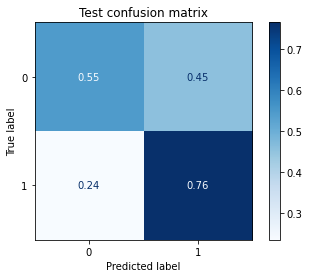

Best: 0.816047 using {'batch_size': 32, 'epochs': 100, 'model__neurons': 160, 'optimizer__learning_rate': 0.0001}


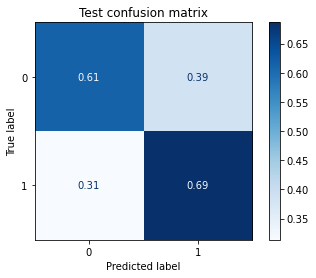

             dataset  AUC-train  AUC-t-std  Accuracy-train  Accuracy-t-std  \
0         Everything     0.9295     0.0078          0.8381          0.0147   
1  Feature Selection     0.8561     0.0113          0.7747          0.0118   

   Precision-train  Precision-t-std  Recall-train  Recall-t-std  \
0           0.8443           0.0158        0.8450        0.0209   
1           0.7633           0.0145        0.8226        0.0130   

   F1 score-train  ...  AUC-test  Accuracy-test  Precision-test  Recall-test  \
0          0.8445  ...    0.6551         0.6632          0.6610       0.7647   
1          0.7918  ...    0.6500         0.6526          0.6731       0.6863   

   F1 score-test                                             params  fit-time  \
0         0.7091  {'batch_size': 32, 'epochs': 150, 'model__neur...    2.9894   
1         0.6796  {'batch_size': 32, 'epochs': 100, 'model__neur...    2.2771   

    fit-std  score-time  score-std  
0  0.144229      0.2774   0.031883  
1  0

In [15]:
nn_results = pd.DataFrame(columns = ['dataset','AUC-train', 'AUC-t-std','Accuracy-train','Accuracy-t-std',
                                      'Precision-train', 'Precision-t-std','Recall-train', 'Recall-t-std',
                                      'F1 score-train', 'F1 score-t-std','AUC-cv', 'AUC-std','Accuracy-cv','Accuracy-std',
                                      'Precision-cv', 'Precision-std','Recall-cv', 'Recall-std',
                                      'F1 score-cv', 'F1 score-std', 'AUC-test', 'Accuracy-test',
                                      'Precision-test', 'Recall-test', 'F1 score-test','params',
                                      'fit-time', 'fit-std', 'score-time', 'score-std'])
nn_val = pd.DataFrame(columns = ['dataset','AUC', 'Accuracy','Precision', 'Recall', 'F1 score'])

model = KerasClassifier(model = create_model, verbose = 0, 
                            optimizer='adam', loss= 'binary_crossentropy'
                            )
es = EarlyStopping(monitor='val_accuracy', mode='max')
for n in range(5,7):
    if n == 1:
        X = X_acust
        dataset = 'Acustic'
        X_val = X_acust_svd
    elif n == 2:
        X = X_spect
        dataset = 'Cepstral'  
        X_val = X_spect_svd
    elif n == 3:
        X = X_all_val
        dataset = 'Everything-val'
        X_val = X_scaled_svd
    elif n == 4 : 
        X = X_ff_val  #From feature selction
        dataset = 'Feature Selection-val'
        X_val = X_ff_svd 
    elif n == 5:
        X = X_scaled
        dataset = 'Everything'
    elif n == 6: 
        X = X_ff  #From feature selction
        dataset = 'Feature Selection'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)
    

    batch = [32,64,128, 256]
    epochs =  [80, 100, 120 , 150]
    neurons = [10, 50,80, 100, 130, 160]
    lrn_rate = np.geomspace(0.00000001, 0.0001, num = 5)
    
    param_grid = dict(epochs = epochs, model__neurons = neurons, optimizer__learning_rate = lrn_rate, batch_size =  batch)

    grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, cv = 10,
                        scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'], refit ='roc_auc', return_train_score=True)

    gdc = grid.fit(X_train, y_train)
    print("Best: %f using %s" % (gdc.best_score_, gdc.best_params_))
    
    y_pred = gdc.predict(X_test)
    auc_test = roc_auc_score(y_test, y_pred)
    acc_test = accuracy_score(y_test, y_pred)
    rec_test = recall_score(y_test, y_pred)
    pre_test = precision_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred)
    
    
    auc_test = roc_auc_score(y_test, y_pred)
    acc_test = accuracy_score(y_test, y_pred)
    rec_test = recall_score(y_test, y_pred)
    pre_test = precision_score(y_test, y_pred)
    f1_test =f1_score(y_test, y_pred)
    
       

    if n in range(1, 5):
        #For validation porpuses, using SVD
        y_pred_svd = gdc.predict(X_val)
        auc_val = roc_auc_score(y_svd, y_pred_svd)
        acc_val = accuracy_score(y_svd, y_pred_svd)
        rec_val = recall_score(y_svd, y_pred_svd)
        pre_val = precision_score(y_svd, y_pred_svd)
        f1_val =f1_score(y_svd, y_pred_svd)

        #Get the confusion matrix for the test and validation data
        cm = confusion_matrix(y_test, y_pred, normalize = 'true')
        cm2 = confusion_matrix(y_svd, y_pred_svd, normalize = 'true')
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
        f.suptitle(dataset)

        #Confusion matrix for test
        ax1.set_title("Test confusion matrix")
        disp1= ConfusionMatrixDisplay(confusion_matrix=cm)
        disp1.plot(ax = ax1, cmap=plt.cm.Blues)
        
                
        #Confusioin matrix of validation
        ax2.set_title("Validation confusion matrix")
        disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
        disp2.plot(ax = ax2, cmap=plt.cm.Oranges)

        #disp.plot(cmap=plt.cm.Oranges)
        #plt.title('Validation confusion matrix')
        
        plt.show()
        
        nn_val = nn_val.append({'dataset': dataset,  
                                'AUC' : auc_val.round(4),  #area under the curve
                                'Accuracy': acc_val.round(4),   #
                                'Precision': pre_val.round(4),   #
                                'Recall' : rec_val.round(4), #how many observations out of all positive observations have we classified as positive
                                'F1 score' : f1_val.round(4)},
                                ignore_index = True)
    else:
        #Get the confusion matrix
        cm = confusion_matrix(y_test, y_pred, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Test confusion matrix')
        plt.show()     

       
    best_index = np.nonzero(gdc.cv_results_["mean_test_roc_auc"] == gdc.best_score_)[0][0]
    auc = gdc.cv_results_["mean_test_roc_auc"][best_index]
    auc_std = gdc.cv_results_["std_test_roc_auc"][best_index]
    acc = gdc.cv_results_["mean_test_accuracy"][best_index]
    acc_std = gdc.cv_results_["std_test_accuracy"][best_index]
    pre = gdc.cv_results_["mean_test_precision"][best_index]
    pre_std = gdc.cv_results_["std_test_precision"][best_index]
    recall = gdc.cv_results_["mean_test_recall"][best_index]
    recall_std = gdc.cv_results_["std_test_recall"][best_index]
    f1 =  gdc.cv_results_["mean_test_f1"][best_index]
    f1_std =  gdc.cv_results_["std_test_f1"][best_index]
    
    auc_train = gdc.cv_results_["mean_train_roc_auc"][best_index]
    auc_train_std = gdc.cv_results_["std_train_roc_auc"][best_index]
    acc_train = gdc.cv_results_["mean_train_accuracy"][best_index]
    acc_train_std = gdc.cv_results_["std_train_accuracy"][best_index]
    pre_train = gdc.cv_results_["mean_train_precision"][best_index]
    pre_train_std = gdc.cv_results_["std_train_precision"][best_index]
    recall_train = gdc.cv_results_["mean_train_recall"][best_index]
    recall_train_std = gdc.cv_results_["std_train_recall"][best_index]
    f1_train =  gdc.cv_results_["mean_train_f1"][best_index]
    f1_train_std =  gdc.cv_results_["std_train_f1"][best_index]
    
    fit_time = gdc.cv_results_["mean_fit_time"][best_index]
    fit_time_std = gdc.cv_results_["std_fit_time"][best_index]
    score_time = gdc.cv_results_["mean_score_time"][best_index]
    score_time_std = gdc.cv_results_["std_score_time"][best_index]
    
    nn_results = nn_results.append({'dataset': dataset, 
                                'AUC-train' : auc_train.round(4),  #area under the curve
                                'AUC-t-std' : auc_train_std.round(4),
                                'Accuracy-train': acc_train.round(4),   #
                                'Accuracy-t-std': acc_train_std.round(4),
                                'Precision-train': pre_train.round(4),   #
                                'Precision-t-std': pre_train_std.round(4),
                                'Recall-train' : recall_train.round(4), #how many observations out of all positive observations have we classified as positive
                                'Recall-t-std' : recall_train_std.round(4),
                                'F1 score-train' : f1_train.round(4),   #It’s the harmonic mean between precision and recall
                                'F1 score-t-std' : f1_train_std.round(4),
                                'AUC-cv' : auc.round(4),  #area under the curve
                                'AUC-std' : auc_std.round(4),
                                'Accuracy-cv': acc.round(4),   #
                                'Accuracy-std': acc_std.round(4),
                                'Precision-cv': pre.round(4),   #
                                'Precision-std': pre_std.round(4),
                                'Recall-cv' : recall.round(4), #how many observations out of all positive observations have we classified as positive
                                'Recall-std' : recall_std.round(4),
                                'F1 score-cv' : f1.round(4),   #It’s the harmonic mean between precision and recall
                                'F1 score-std' : f1_std.round(4),
                                'AUC-test': auc_test.round(4),
                                'Accuracy-test': acc_test.round(4),
                                'Precision-test': pre_test.round(4), 
                                'Recall-test': rec_test.round(4),
                                'F1 score-test': f1_test.round(4),
                                'params' : gdc.best_params_,
                                'fit-time' : fit_time.round(4),
                                'fit-std' : fit_time_std,
                                'score-time' : score_time.round(4),
                                'score-std': score_time_std}, ignore_index = True)
import winsound
winsound.Beep(500, 1500)
print(nn_results)
print(nn_val)

In [9]:
nn_results= nn_results.round(4)
nn_results = pd.concat([nn_results, nn_val])
save = 'nn_' + dts + '.xlsx'
nn_results.to_csv(os.path.join('Modelos', save), index=False)

In [18]:
nn_results.loc[:, 'AUC-cv':'F1 score-test']

,AUC-cv,AUC-std,Accuracy-cv,Accuracy-std,Precision-cv,Precision-std,Recall-cv,Recall-std,F1 score-cv,F1 score-std,AUC-test,Accuracy-test,Precision-test,Recall-test,F1 score-test
0,0.8064,0.1202,0.7071,0.1385,0.7314,0.1707,0.7439,0.0948,0.7299,0.1169,0.6551,0.6632,0.6610,0.7647,0.7091
1,0.8160,0.1119,0.7394,0.1372,0.7330,0.1346,0.7856,0.1358,0.7562,0.1301,0.6500,0.6526,0.6731,0.6863,0.6796
